RQ1: How prominently are key innovation actors represented in national quantum strategies?

Core Goal: Quantifying how prominently each innovation actor is mentioned to gauge their relative importance in a country's strategy.

0. Data Initialization

In [4]:
# Configuration & Setup
OUTPUT_FILE = "output.csv"
ENTITIES_FILE = "entities_to_edit.csv"

1. Master Statistics: Performs a preliminary structural analysis of the corpus, calculating key metrics such as character counts, paragraph counts, and sentence density. It computes an Actor Density Index (actors per 100 sentences) to normalize actor frequency against document length, ensuring comparability across nations.

In [5]:
import pandas as pd
import nltk
import re
from nltk.tokenize import sent_tokenize

STATS_FILENAME = "master_statistics_full.csv"

# Versuche NLTK zu laden, setze Flag für Fallback wenn offline
try:
    nltk.data.find('tokenizers/punkt')
    nltk_available = True
except LookupError:
    # Automatischer Download Versuch
    try:
        nltk.download('punkt', quiet=True)
        nltk.download('punkt_tab', quiet=True)
        nltk_available = True
    except:
        nltk_available = False
        print("⚠️ Warnung: NLTK Daten nicht verfügbar. Nutze einfachen Fallback-Tokenizer.")

def robust_sentence_count(text):
    """Zählt Sätze robust, egal ob NLTK installiert ist oder nicht."""
    if not isinstance(text, str) or not text.strip():
        return 0
    if nltk_available:
        try:
            return len(sent_tokenize(text))
        except:
            pass # Fallback bei unerwartetem NLTK Fehler
    # Fallback: Split bei Satzzeichen (.?!) gefolgt von Leerzeichen
    return len(re.split(r'[.?!]\s+', text))

# --- 1. DATEN LADEN ---
try:
    output_df = pd.read_csv(OUTPUT_FILE)
    entities_df = pd.read_csv(ENTITIES_FILE)
except FileNotFoundError as e:
    print(f"❌ Kritischer Fehler: Datei nicht gefunden ({e})")
    exit()

# --- 2. BASIS-STATISTIKEN (Dokumente & Paragraphen) ---
if not output_df.empty:
    output_df['char_count'] = output_df['text'].fillna('').str.len()
    
    # Aggregation auf Länderebene
    stats_base = output_df.groupby('Country').agg(
        Documents=('Doc_ID', 'nunique'),
        Total_Paragraphs=('Paragraph_ID', 'count'),
        Total_Characters=('char_count', 'sum')
    ).reset_index()

    # --- 3. AKTEURS-STATISTIKEN (Entities) ---
    valid_qh = ['Academia', 'Government', 'Industry', 'Civil Society']
    filtered_entities = entities_df[entities_df['qh_category'].isin(valid_qh)]
    
    # Zählen und Mergen
    entity_counts = filtered_entities.groupby('Country').size().reset_index(name='Total_QH_Actors')
    master_table = pd.merge(stats_base, entity_counts, on='Country', how='left').fillna(0)
    master_table['Total_QH_Actors'] = master_table['Total_QH_Actors'].astype(int)

    # --- 4. ADVANCED STATISTIKEN (Satz-Ebene) ---
    output_df['sentence_count'] = output_df['text'].apply(robust_sentence_count)
    
    # Summe der Sätze pro Land
    sent_stats = output_df.groupby('Country')['sentence_count'].sum().reset_index(name='Total_Sentences')
    master_table = pd.merge(master_table, sent_stats, on='Country', how='left')

    # --- 5. ABGELEITETE METRIKEN BERECHNEN ---
    # Durchschnittliche Zeichen pro Satz (Komplexität)
    master_table['Avg_Chars_per_Sentence'] = master_table['Total_Characters'] / master_table['Total_Sentences']
    
    # Durchschnittliche Sätze pro Paragraph (Struktur)
    master_table['Avg_Sentences_per_Para'] = master_table['Total_Sentences'] / master_table['Total_Paragraphs']
    
    # Akteurs-Dichte (Wie viele Akteure kommen auf 100 Sätze?)
    master_table['Actors_per_100_Sentences'] = (master_table['Total_QH_Actors'] / master_table['Total_Sentences']) * 100

    # Bereinigung von möglichen Teilungs-Fehlern (Division by Zero)
    master_table = master_table.fillna(0)

    # --- 6. AUSGABE & SPEICHERN ---
    pd.options.display.float_format = '{:,.2f}'.format
    
    print("\n--- 1. Master Statistics ---")
    print(master_table.to_string(index=False))
    
    master_table.to_csv(STATS_FILENAME, index=False)
else:
    print("Keine Daten zum Verarbeiten vorhanden.")


--- 1. Master Statistics ---
Country  Documents  Total_Paragraphs  Total_Characters  Total_QH_Actors  Total_Sentences  Avg_Chars_per_Sentence  Avg_Sentences_per_Para  Actors_per_100_Sentences
    CAN          1               147             84942               97              487                  174.42                    3.31                     19.92
    GER          1               172            139300              169              810                  171.98                    4.71                     20.86
     UK          1               161            134319              144              688                  195.23                    4.27                     20.93
    USA          1                48             44202               41              228                  193.87                    4.75                     17.98


2. Actor Distribution (Absolute Counts): Filters and aggregates actor mentions according to the Quadruple Helix (QH) framework (Academia, Government, Industry, Civil Society).

In [6]:
try:
    entities_df = pd.read_csv("entities_to_edit.csv")
    valid_qh = ['Academia', 'Government', 'Industry', 'Civil Society']
    
    # Filter & Count
    filtered = entities_df[entities_df['qh_category'].isin(valid_qh)]
    actor_stats = filtered.groupby(['Country', 'qh_category']).size().unstack(fill_value=0)
    
    # Add Total column
    actor_stats['Total_Actors'] = actor_stats.sum(axis=1)
    
    print("--- 2. ACTOR DISTRIBUTION ---")
    print(actor_stats)

except FileNotFoundError:
    print("Error: 'entities_to_edit.csv' not found.")

--- 2. ACTOR DISTRIBUTION ---
qh_category  Academia  Civil Society  Government  Industry  Total_Actors
Country                                                                 
CAN                16              8          66         7            97
GER                84             19          36        30           169
UK                 39             24          60        21           144
USA                 2              1          38         0            41


3. Ecosystem Balance Assessment (Shannon Entropy): Computes the "Ecosystem Balance Score" for each national strategy and applies Shannon Entropy, an information-theoretic measure, to quantify the diversity of actor representation. 

High Entropy: Indicates a heterarchical ecosystem with balanced representation across sectors. 

Low Entropy: Indicates a hierarchical or monochromatic ecosystem dominated by a single sector.

In [7]:
import numpy as np

def calculate_entropy(df):
    # Anteil jeder Kategorie berechnen
    counts = df['qh_category'].value_counts(normalize=True)
    # Shannon Entropie Formel: -sum(p * log(p))
    entropy = -np.sum(counts * np.log2(counts + 1e-9)) # +1e-9 verhindert log(0)
    return entropy

try:
    entities_df = pd.read_csv("entities_to_edit.csv")
    valid_qh = ['Academia', 'Government', 'Industry', 'Civil Society']
    filtered = entities_df[entities_df['qh_category'].isin(valid_qh)]
    
    # Entropie pro Land berechnen
    balance_score = filtered.groupby('Country').apply(calculate_entropy).reset_index(name='Ecosystem_Balance_Score')
    
    print("--- 3. ECOSYSTEM-BALANCE ---")
    print(balance_score.sort_values('Ecosystem_Balance_Score', ascending=False).round(3))

except FileNotFoundError:
    print("Fehler: entities_to_edit.csv nicht gefunden.")

--- 3. ECOSYSTEM-BALANCE ---
  Country  Ecosystem_Balance_Score
2      UK                     1.87
1     GER                     1.77
0     CAN                     1.38
3     USA                     0.45


C:\Users\user\AppData\Local\Temp\ipykernel_27956\1295925704.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balance_score = filtered.groupby('Country').apply(calculate_entropy).reset_index(name='Ecosystem_Balance_Score')


4. Hierarchical Sub-Category Decomposition: Performs a granular analysis of actor roles within the primary QH categories.

In [8]:
import pandas as pd

# 1. DATEN LADEN
try:
    df = pd.read_csv("entities_to_edit.csv")
    
    # 2. FILTERN
    valid_qh = ['Academia', 'Government', 'Industry', 'Civil Society']
    
    # Sicherstellen, dass die Spalten existieren
    if 'qh_category' in df.columns and 'qh_sub_category' in df.columns:
        filtered = df[df['qh_category'].isin(valid_qh)].copy()
        
        # Leere Sub-Kategorien füllen
        filtered['qh_sub_category'] = filtered['qh_sub_category'].fillna('Unspecified')
        
        # 3. ZÄHLEN & SORTIEREN
        stats = filtered.groupby(['qh_category', 'qh_sub_category']).size().reset_index(name='Frequency')
        stats = stats.sort_values(by=['qh_category', 'Frequency'], ascending=[True, False])
        
        # 4. HIERARCHISCHE AUSGABE
        print("\n--- 4. HIERARCHISCHE SUB-KATEGORIEN STATISTIK ---")
        
        current_cat = None
        for _, row in stats.iterrows():
            cat = row['qh_category']
            sub = row['qh_sub_category']
            freq = row['Frequency']
            
            # Gruppen-Header (Hauptkategorie)
            if cat != current_cat:
                cat_total = stats[stats['qh_category'] == cat]['Frequency'].sum()
                print(f"\n📂 {cat.upper()} (Gesamt: {cat_total})")
                current_cat = cat
            
            # Subkategorie mit Prozentanteil
            pct = (freq / cat_total) * 100
            bar = "█" * int(pct / 5) # ASCII Balken für Visualisierung
            print(f"   ├── {sub}: {freq} ({pct:.1f}%) {bar}")

        # CSV speichern
        stats.to_csv("hierarchical_subcategories.csv", index=False)
        
    else:
        print("❌ Spalten 'qh_category' oder 'qh_sub_category' fehlen.")

except FileNotFoundError:
    print("❌ Datei 'entities_to_edit.csv' nicht gefunden.")


--- 4. HIERARCHISCHE SUB-KATEGORIEN STATISTIK ---

📂 ACADEMIA (Gesamt: 141)
   ├── Public Research Orgs (PROs): 112 (79.4%) ███████████████
   ├── Higher Education Institutions (HEIs): 25 (17.7%) ███
   ├── Research Consortium: 3 (2.1%) 
   ├── Education & Skills Provider: 1 (0.7%) 

📂 CIVIL SOCIETY (Gesamt: 52)
   ├── Intermediaries: 52 (100.0%) ████████████████████

📂 GOVERNMENT (Gesamt: 200)
   ├── Policy Makers: 70 (35.0%) ███████
   ├── Funding Agencies: 38 (19.0%) ███
   ├── Federal Agency: 28 (14.0%) ██
   ├── Public Research Orgs (PROs): 21 (10.5%) ██
   ├── Government Support Services: 14 (7.0%) █
   ├── Intergovernmental Organization: 13 (6.5%) █
   ├── Bank: 4 (2.0%) 
   ├── Regulatory Agency: 4 (2.0%) 
   ├── Federal Research Organization: 2 (1.0%) 
   ├── National Intelligence Agency: 2 (1.0%) 
   ├── Strategic Defense Partnership: 2 (1.0%) 
   ├── Public Administration: 1 (0.5%) 
   ├── Unspecified: 1 (0.5%) 

📂 INDUSTRY (Gesamt: 58)
   ├── Private Firms (Corporates): 28

5b: Sunburst Chart

In [1]:
import pandas as pd
import plotly.express as px
import os

# --- KONFIGURATION ---
FILENAME = "entities_to_edit.csv"
VALID_QH = ['Academia', 'Government', 'Industry', 'Civil Society']

def main():
    # 1. DATEN LADEN
    if not os.path.exists(FILENAME):
        print(f"❌ Datei '{FILENAME}' nicht gefunden.")
        return

    df = pd.read_csv(FILENAME)

    # Prüfen, ob notwendige Spalten existieren
    if 'qh_category' not in df.columns or 'qh_sub_category' not in df.columns:
        print("❌ Spalten 'qh_category' oder 'qh_sub_category' fehlen.")
        return

    # 2. FILTERN & BEREINIGEN
    # Nur valide Hauptkategorien behalten
    filtered = df[df['qh_category'].isin(VALID_QH)].copy()
    
    # Leere Sub-Kategorien füllen
    filtered['qh_sub_category'] = filtered['qh_sub_category'].fillna('Unspecified')

    # 3. ZÄHLEN (Daten für den Chart vorbereiten)
    stats = filtered.groupby(['qh_category', 'qh_sub_category']).size().reset_index(name='Frequency')
    stats = stats.sort_values(by=['qh_category', 'Frequency'], ascending=[True, False])

    # --- TEXT OUTPUT (Wie in deinem Original-Code) ---
    print("\n--- 4. HIERARCHISCHE SUB-KATEGORIEN STATISTIK ---")
    
    current_cat = None
    for _, row in stats.iterrows():
        cat = row['qh_category']
        sub = row['qh_sub_category']
        freq = row['Frequency']
        
        # Berechnung der Gesamtsumme pro Kategorie für Prozentanteile
        cat_total = stats[stats['qh_category'] == cat]['Frequency'].sum()
        
        # Neuer Header für Hauptkategorie
        if cat != current_cat:
            print(f"\n📂 {cat.upper()} (Gesamt: {cat_total})")
            current_cat = cat
        
        # Text-Visualisierung
        pct = (freq / cat_total) * 100
        bar = "█" * int(pct / 5) 
        print(f"   ├── {sub}: {freq} ({pct:.1f}%) {bar}")

    # --- 5. INTERAKTIVER SUNBURST CHART ---
    print("\n📊 Erstelle Sunburst Chart...")

    try:
        fig = px.sunburst(
            stats, 
            path=['qh_category', 'qh_sub_category'], # Die Hierarchie definieren
            values='Frequency',
            title='<b>Quadruple Helix Distribution</b>',
            color='qh_category', # Segmente nach Hauptkategorie färben
            # Optionale Farbanpassung (Beispiel)
            color_discrete_map={
                'Academia': '#636EFA',
                'Government': '#EF553B',
                'Industry': '#00CC96',
                'Civil Society': '#AB63FA'
            }
        )

        # Hover-Infos verbessern (Label + Prozent vom Eintrag)
        fig.update_traces(textinfo="label+percent entry")
        
        # Chart im Browser anzeigen
        fig.show()
        
        # Optional: Als HTML speichern
        fig.write_html("hierarchy_chart.html")
        print("✅ Chart wurde im Browser geöffnet und als 'hierarchy_chart.html' gespeichert.")

    except Exception as e:
        print(f"❌ Fehler beim Erstellen des Charts: {e}")

if __name__ == "__main__":
    main()


--- 4. HIERARCHISCHE SUB-KATEGORIEN STATISTIK ---

📂 ACADEMIA (Gesamt: 141)
   ├── Public Research Orgs (PROs): 112 (79.4%) ███████████████
   ├── Higher Education Institutions (HEIs): 25 (17.7%) ███
   ├── Research Consortium: 3 (2.1%) 
   ├── Education & Skills Provider: 1 (0.7%) 

📂 CIVIL SOCIETY (Gesamt: 52)
   ├── Intermediaries: 52 (100.0%) ████████████████████

📂 GOVERNMENT (Gesamt: 200)
   ├── Policy Makers: 70 (35.0%) ███████
   ├── Funding Agencies: 38 (19.0%) ███
   ├── Federal Agency: 28 (14.0%) ██
   ├── Public Research Orgs (PROs): 21 (10.5%) ██
   ├── Government Support Services: 14 (7.0%) █
   ├── Intergovernmental Organization: 13 (6.5%) █
   ├── Bank: 4 (2.0%) 
   ├── Regulatory Agency: 4 (2.0%) 
   ├── Federal Research Organization: 2 (1.0%) 
   ├── National Intelligence Agency: 2 (1.0%) 
   ├── Strategic Defense Partnership: 2 (1.0%) 
   ├── Public Administration: 1 (0.5%) 
   ├── Unspecified: 1 (0.5%) 

📂 INDUSTRY (Gesamt: 58)
   ├── Private Firms (Corporates): 28

✅ Chart wurde im Browser geöffnet und als 'hierarchy_chart.html' gespeichert.


6. Visualization of Absolute Actor Prominence: Visualizes the total volume of actor mentions via a stacked bar chart.

Loaded entities: 648 rows.


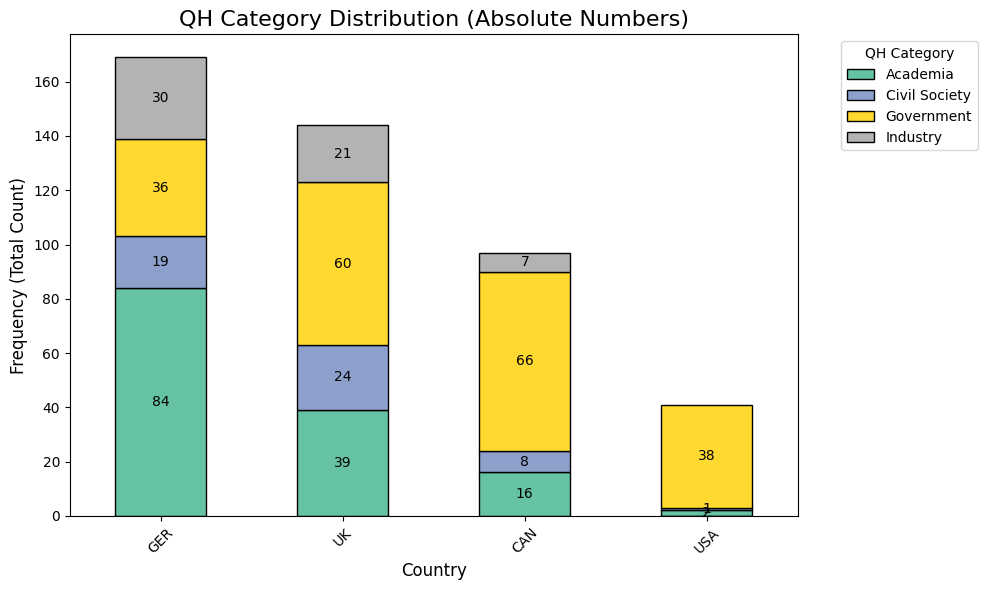

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. LOAD DATA
try:
    entities_df = pd.read_csv("entities_to_edit.csv")
    print(f"Loaded entities: {len(entities_df)} rows.")
except FileNotFoundError:
    print("Error: 'entities_to_edit.csv' not found.")
    entities_df = pd.DataFrame()

if not entities_df.empty:
    # 2. FILTER FOR QH ACTORS ONLY
    valid_qh_actors = ['Academia', 'Government', 'Industry', 'Civil Society']
    filtered_df = entities_df[entities_df['qh_category'].isin(valid_qh_actors)].copy()
    
    if filtered_df.empty:
        print("Alert: No data remained after filtering.")
    else:
        # 3. VISUALIZE
        # Group by Country and QH Category
        counts = filtered_df.groupby(['Country', 'qh_category']).size().reset_index(name='Frequency')

        # Pivot for the stacked chart
        pivot_df = counts.pivot_table(
            index='Country', 
            columns='qh_category', 
            values='Frequency', 
            aggfunc='sum'
        ).fillna(0)
        
        # Sort by volume
        pivot_df['Total'] = pivot_df.sum(axis=1)
        pivot_df = pivot_df.sort_values('Total', ascending=False).drop(columns='Total')
        
        # Plot
        ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2', edgecolor='black')
        
        # --- NEU: ABSOLUTE ZAHLEN HINZUFÜGEN ---
        for c in ax.containers:
            # Wir zeigen die Zahl nur an, wenn sie größer als 0 ist
            labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='center', fontsize=10)

        plt.title('QH Category Distribution (Absolute Numbers)', fontsize=16)
        plt.xlabel('Country', fontsize=12)
        plt.ylabel('Frequency (Total Count)', fontsize=12)
        plt.xticks(rotation=45)
        plt.legend(title='QH Category', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

else:
    print("No data loaded.")

7. QH Category Distribution (% of Actors per Country)

Geladen: 648 Zeilen.


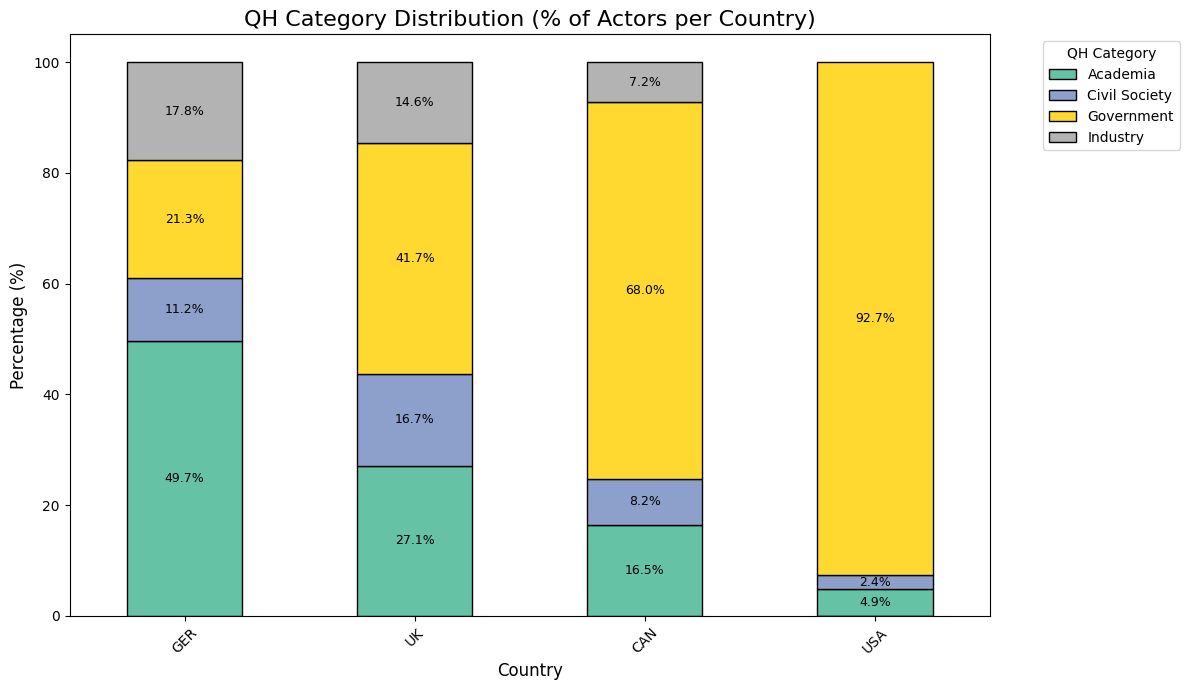

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. DATEN LADEN
try:
    entities_df = pd.read_csv("entities_to_edit.csv")
    print(f"Geladen: {len(entities_df)} Zeilen.")
except FileNotFoundError:
    print("Fehler: 'entities_to_edit.csv' nicht gefunden.")
    entities_df = pd.DataFrame()

if not entities_df.empty:
    # 2. FILTERN
    valid_qh_actors = ['Academia', 'Government', 'Industry', 'Civil Society']
    filtered_df = entities_df[entities_df['qh_category'].isin(valid_qh_actors)].copy()
    
    if filtered_df.empty:
        print("Keine Daten nach Filterung übrig.")
    else:
        # 3. DATEN VORBEREITEN
        counts = filtered_df.groupby(['Country', 'qh_category']).size().reset_index(name='Frequency')
        pivot_df = counts.pivot_table(
            index='Country', 
            columns='qh_category', 
            values='Frequency', 
            aggfunc='sum'
        ).fillna(0)
        
        # In Prozent umrechnen
        pivot_df_percent = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
        
        # Sortieren nach Gesamtanzahl der Akteure (optional)
        total_counts = pivot_df.sum(axis=1).sort_values(ascending=False)
        pivot_df_percent = pivot_df_percent.reindex(total_counts.index)
        
        # 4. VISUALISIERUNG
        ax = pivot_df_percent.plot(
            kind='bar', 
            stacked=True, 
            figsize=(12, 7), 
            colormap='Set2', 
            edgecolor='black'
        )
        
        # --- NEU: PROZENTZAHLEN HINZUFÜGEN ---
        for c in ax.containers:
            # Wir zeigen das Label nur an, wenn der Wert > 0 ist, um Überlappungen zu vermeiden
            labels = [f'{v.get_height():.1f}%' if v.get_height() > 0 else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='center', fontsize=9)

        plt.title('QH Category Distribution (% of Actors per Country)', fontsize=16)
        plt.xlabel('Country', fontsize=12)
        plt.ylabel('Percentage (%)', fontsize=12)
        plt.xticks(rotation=45)
        plt.ylim(0, 105) # Etwas Platz nach oben lassen
        
        plt.legend(title='QH Category', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

8. Normalized Actor Density Visualization: Visualizes the relative intensity of actor representation, controlling for variable document lengths. Plots the number of Actors per 10,000 characters. This normalization is critical for validity, ensuring that concise strategies (e.g., USA) are compared fairly against extensive documents (e.g., Germany) based on density rather than volume.

Daten geladen. Entities: 648, Text-Abschnitte: 528


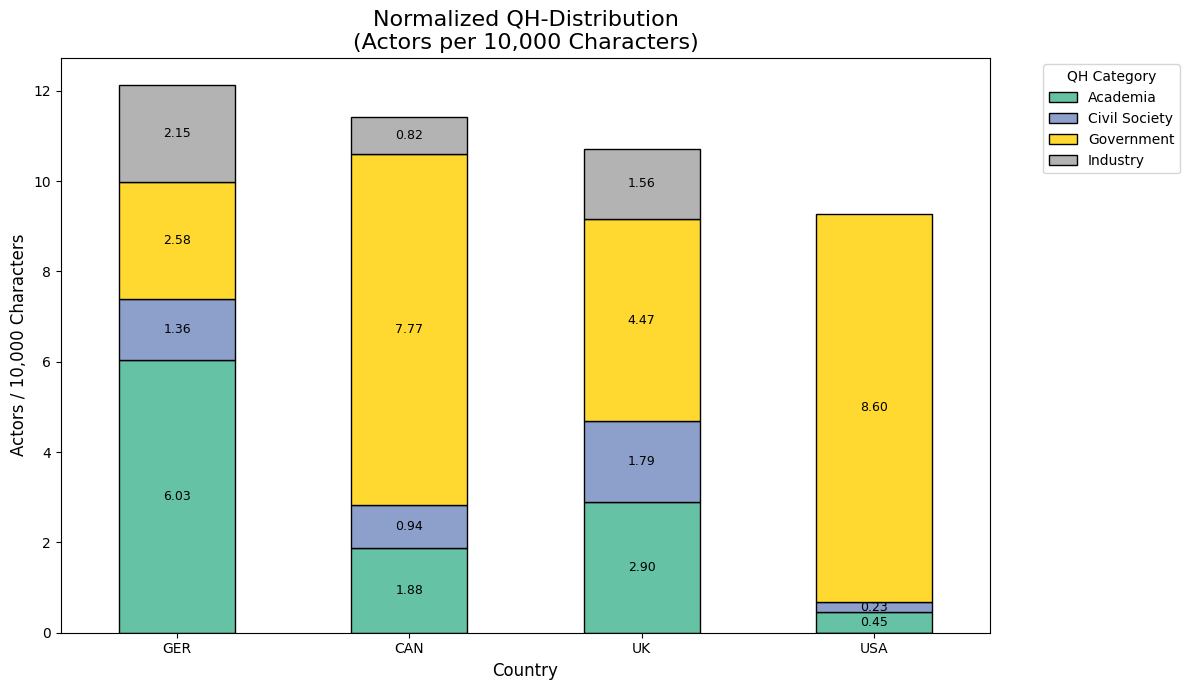

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. DATEN LADEN
try:
    entities_df = pd.read_csv("entities_to_edit.csv")
    output_df = pd.read_csv("output.csv")
    print(f"Daten geladen. Entities: {len(entities_df)}, Text-Abschnitte: {len(output_df)}")
except FileNotFoundError as e:
    print(f"Fehler: {e}")
    entities_df = pd.DataFrame()
    output_df = pd.DataFrame()

if not entities_df.empty and not output_df.empty:
    # 2. TEXTLÄNGE PRO LAND BERECHNEN (aus output.csv)
    # Wir summieren die Zeichenanzahl aller Texte pro Land
    output_df['text_len'] = output_df['text'].fillna('').str.len()
    country_lengths = output_df.groupby('Country')['text_len'].sum().reset_index()
    country_lengths.rename(columns={'text_len': 'total_text_length'}, inplace=True)
    
    # 3. FILTER FÜR QH AKTEURE
    valid_qh_actors = ['Academia', 'Government', 'Industry', 'Civil Society']
    filtered_df = entities_df[entities_df['qh_category'].isin(valid_qh_actors)].copy()
    
    # 4. ABSOLUTE ANZAHLEN BERECHNEN
    counts = filtered_df.groupby(['Country', 'qh_category']).size().reset_index(name='Frequency')
    
    # 5. ZUSAMMENFÜHREN UND NORMALISIEREN
    # Normalisierung: (Anzahl / Gesamtzeichen) * 10.000
    merged = pd.merge(counts, country_lengths, on='Country')
    merged['Normalized_Freq'] = (merged['Frequency'] / merged['total_text_length']) * 10000
    
    # 6. PIVOT-TABELLE FÜR DIE GRAFIK
    pivot_df = merged.pivot_table(
        index='Country', 
        columns='qh_category', 
        values='Normalized_Freq', 
        aggfunc='sum'
    ).fillna(0)
    
    # Sortieren nach der gesamten normalisierten Dichte
    pivot_df['Total_Norm'] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values('Total_Norm', ascending=False).drop(columns='Total_Norm')
    
    # 7. VISUALISIERUNG
    ax = pivot_df.plot(
        kind='bar', 
        stacked=True, 
        figsize=(12, 7), 
        colormap='Set2', 
        edgecolor='black'
    )
    
    # Beschriftungen hinzufügen (2 Dezimalstellen)
    for c in ax.containers:
        labels = [f'{v.get_height():.2f}' if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontsize=9)
    
    plt.title('Normalized QH-Distribution\n(Actors per 10,000 Characters)', fontsize=16)
    plt.xlabel('Country', fontsize=12)
    plt.ylabel('Actors / 10,000 Characters', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='QH Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

    # Optional: Save the normalized data
    pivot_df.to_csv("normalized_actor_counts.csv")
else:
    print("Data could not be processed.")